# Análise de dados - Curva característica do diodo e do painel solar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.constants import e, k

import exp_physics as ep

In [2]:
#plt.rcParams['figure.figsize'] = (10, 8)
#plt.rcParams['figure.facecolor'] = 'white'
sns.set_theme()

## Diodo

In [3]:
df_diodo = pd.read_csv('./Dados/diodo.csv')

In [4]:
R = 330.2, 0.1	# Resistência e incerteza

In [5]:
popt, pcov = curve_fit(
	lambda x, H, A, b: H + A * np.exp(b * x),
	xdata=np.arange(0, 200),
	ydata=df_diodo['Tensao A'][0:200],
	p0=[ 0, 0.00015, 0.01 ]
)

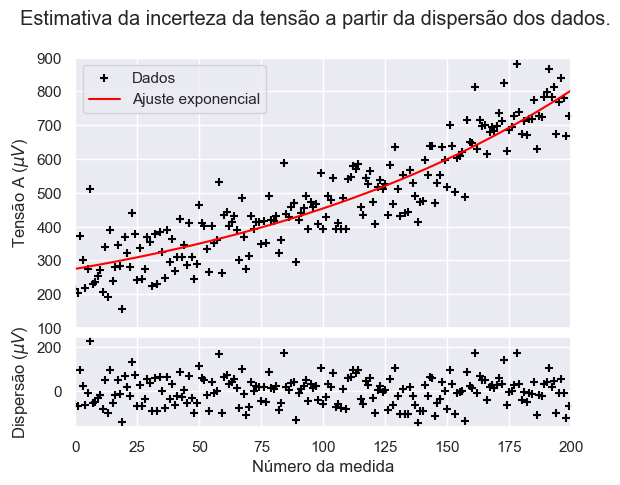

In [6]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'height_ratios': (3,1), 'hspace': 0.05 })
plt.suptitle('Estimativa da incerteza da tensão a partir da dispersão dos dados.')

axs[0].scatter(np.arange(0, 200), df_diodo['Tensao A'][0:200] * 1E6, label='Dados', marker='+', color='black')

x = np.linspace(0, 200, 1000)
axs[0].plot(x, (popt[0]+popt[1]*np.exp(popt[2]*x))*1E6, color='red', label='Ajuste exponencial')

axs[0].set_ylim(100, 900)
axs[0].set_ylabel('Tensão A ($\mu V$)')
axs[0].legend()

axs[1].scatter( np.arange(0, 200), (df_diodo['Tensao A'][0:200] - popt[0]-popt[1]*np.exp(popt[2]*np.arange(0, 200)))*1E6, marker='+', color='black')

axs[1].set_ylabel('Dispersão ($\mu V$)')
axs[1].set_xlabel('Número da medida')
axs[1].set_xlim(0, 200)

plt.savefig('Plots/diode_dipersion.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
sigma = df_diodo['Tensao A'][0:200] - popt[0] - popt[1] * np.exp(popt[2]*np.arange(0, 200))

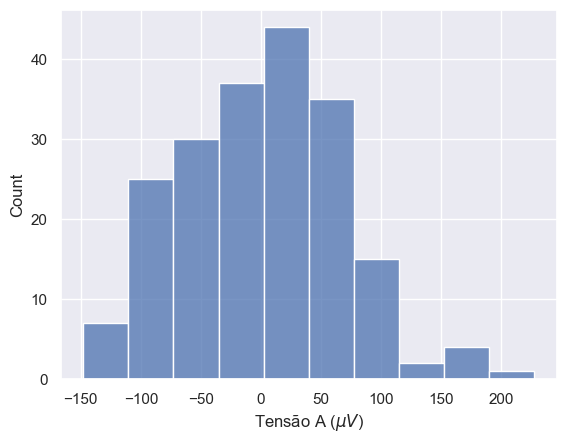

In [8]:
sns.histplot(sigma*1E6, bins=10)
plt.xlabel('Tensão A ($\mu V$)')
plt.show()

In [9]:
df_diodo['sTensao A']	= df_diodo['Tensao A'] * 0 + sigma.std()
df_diodo['sTensao B']	= df_diodo['Tensao A'] * 0 + sigma.std()

#df_diodo['Corrente']	= df_diodo['Tensao A'] / R[0]
df_diodo['sCorrente']	= np.sqrt(( df_diodo['sTensao A'] / R[0] )**2 + ( df_diodo['Tensao A'] * R[1] / R[0]**2 )**2)

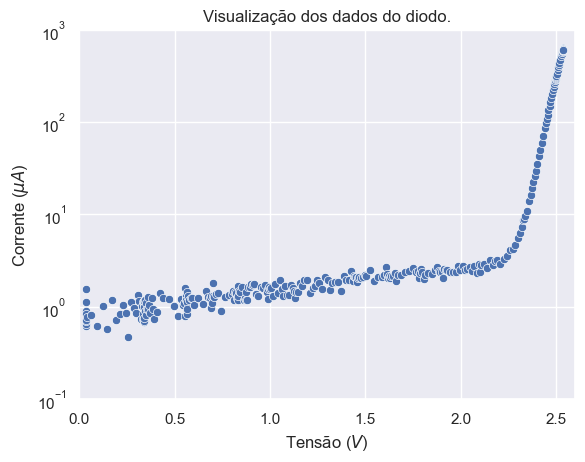

In [10]:
plt.title('Visualização dos dados do diodo.')
sns.scatterplot(x=df_diodo['Tensao B'], y=df_diodo['Corrente']*1E6)
plt.yscale('log')
plt.xlim(0, 2.6)
plt.ylim(1E-1, 1E3)
plt.xlabel('Tensão ($V$)')
plt.ylabel('Corrente ($\mu A$)')
plt.savefig('Plots/diode_visual.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
df_fit = df_diodo.loc[(df_diodo['Tensao B'] > 2.3) & (df_diodo['Tensao B'] < 2.5)]

In [12]:
popt, pcov = curve_fit(
	lambda x, H, I, b: H + I * (np.exp(b*x) - 1),
	xdata=df_fit['Tensao B'],
	ydata=df_fit['Corrente'],
	sigma=df_fit['sCorrente'],
	p0=[ 3E-6, 6.290535404538017e-27, 20.96174081],
	maxfev=10000
)

In [13]:
popt

array([-7.81346382e-07,  1.52290794e-27,  2.14726168e+01])

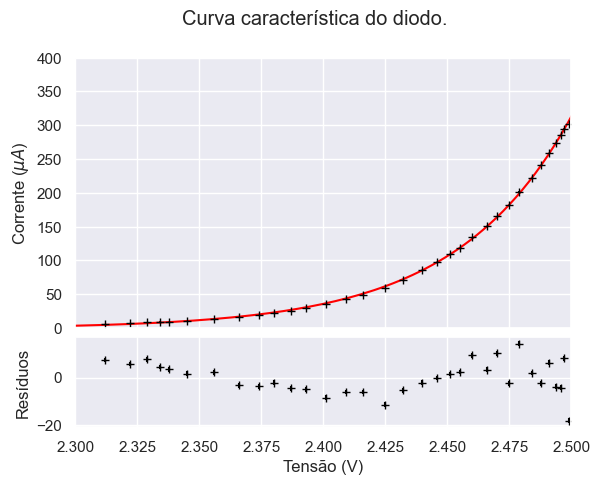

In [14]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'height_ratios': (3,1), 'hspace': 0.05 })
plt.suptitle('Curva característica do diodo.')

axs[0].errorbar(
	x=df_fit['Tensao B'],
	y=df_fit['Corrente'] * 1E6,
	xerr=df_fit['sTensao B'],
	yerr=df_fit['sCorrente'] * 1E6,
	fmt=' ', marker='+', color='black'
)

x = np.linspace(0, 2.6, 1000)
sns.lineplot(x=x, y=(popt[0]+popt[1]*(np.exp(popt[2]*x)-1))*1E6, color='red', ax=axs[0])

axs[1].errorbar(
	x=df_fit['Tensao B'],
	y=( df_fit['Corrente'] - popt[0] - popt[1] * ( np.exp(popt[2]*df_fit['Tensao B']) - 1 ) ) / df_fit['sCorrente'],
	xerr=df_fit['sTensao B'],
	yerr=1,
	fmt=' ', marker='+', color='black'
)

axs[0].set_ylabel('Corrente ($\mu A$)')
axs[0].set_xlim(2.3, 2.5)
axs[0].set_ylim(0, 400)

axs[1].set_ylabel('Resíduos')
axs[1].set_xlabel('Tensão (V)')

plt.savefig('Plots/diode_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
e / (k * popt[2]) - 273

267.43334569973103

In [16]:
np.sum( ( df_fit['Corrente'] - popt[0] - popt[1] * ( np.exp(popt[2]*df_fit['Tensao B']) - 1 ) )**2 / (df_fit['sCorrente'])**2 ) / df_fit.shape[0]

44.20516362393653

## Painel Solar

In [17]:
df_painel = pd.read_csv('./Dados/painel_solar.csv')

In [18]:
df_painel

,Tempo,Tensao A,Tensao B,Corrente
0,0.00,0.015,6.273,0.00
1,0.05,0.015,6.271,0.00
2,0.10,0.015,6.271,0.00
3,0.15,0.015,6.272,0.00
4,0.20,0.015,6.273,0.00
...,...,...,...,...
774,38.70,0.075,0.141,0.02
775,38.75,0.075,0.141,0.02
776,38.80,0.075,0.141,0.02
777,38.85,0.075,0.141,0.02


In [19]:
df_painel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tempo     779 non-null    float64
 1   Tensao A  779 non-null    float64
 2   Tensao B  779 non-null    float64
 3   Corrente  779 non-null    float64
dtypes: float64(4)
memory usage: 24.5 KB


In [20]:
R = 4.7, 0.05

In [21]:
df_painel['Corrente'] = df_painel['Tensao A'] / R[0]

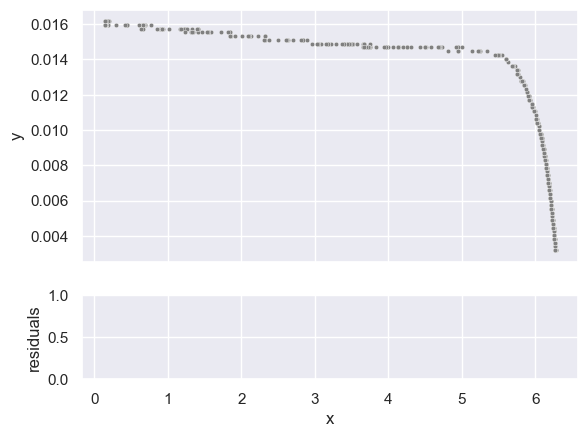

In [26]:
ep.residual_plot(x=df_painel['Tensao B'], y=df_painel['Corrente'])
plt.show()

In [29]:
T = 300
fitfunc = lambda V, iL, i0, n, b: iL - i0*(np.exp(b*V/n)-1)

In [36]:
bapprox = e/(k*T)

In [37]:
bapprox

38.681727071833606

In [38]:
fit, cov = curve_fit(fitfunc,
                    df_painel['Tensao B'],
                    df_painel['Corrente'],
                    p0=[0.016, 0.001, 100, bapprox],
                    maxfev=10000)

In [39]:
fit

array([1.53373275e-02, 9.88904677e-13, 3.19355040e+01, 1.18237054e+02])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

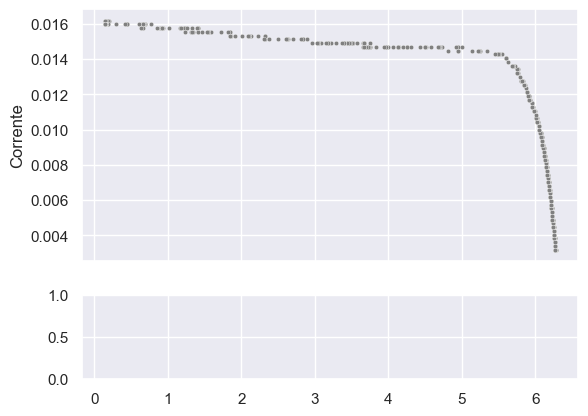

In [40]:
ep.residual_plot(x= df_painel['Tensao B'],
                y= df_painel['Corrente'],
                func = fitfunc,
                params= fit,
                x_title='Tensão (V)',
                y_title='Corrente (A)',
                residual_title='Resíduos',
                title='Curva característica do painel solar',
)

In [27]:
ep.chisquare(vals = df_painel['Corrente'],
             exp= fitfunc(df_painel['Tensao B'], *fit)
)

TypeError: chisquare() missing 1 required positional argument: 'sigma'